In [173]:
import sys
sys.path.insert(0,'C:\\Users\\joclo\\Python_FE_CBS\\python_for_the_financial_economist-master\\python_for_the_financial_economist-master\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""

# numpy for working with matrices
import numpy as np
import math
# pandas
import pandas as pd

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# working with dates
import datetime

# scipy of statistics and optimization
from scipy import stats
from scipy import optimize

# typehints
from typing import Union, List

"""
Own packages
"""
from codelib.dal.fred_yield_data import get_nominal_yield_data

from codelib.visualization.base import correlation_plot, fan_chart
from codelib.visualization.layout import DefaultStyle, default_colors
DefaultStyle();

from codelib.fixed_income.curves.vasicek_curve import VasicekCurve

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**PART 2: Task 1, simulating the distribution of the risk free asset**

In [174]:
#Simulating risk free interest rate 
np.random.seed(123)
def simulate_vasicek(initial_short_rate: float, kappa: float, theta: float,
                     beta: float, horizon: float, 
                     dt: float=1.0/52, num_sim: int=1000):
    """
    simulates short rate processes in a vasicek setting until a given horizon 
    
    Parameters
    ----------
    
    initial_short_rate:
        initial short rate
    kappa: 
        speed of mean reversion.
    theta: 
        long term mean of the short rate.
    dt:
        increments in time
    horizon:
        time until maturity/expiry (horizon).
    num_sim:
        number of simulations.
    """
    std_rates = np.sqrt(beta**2 / (2 * kappa) * (1 - np.exp(-2 * kappa * dt)))
    
    num_periods = int(horizon / dt)
    short_rates = np.empty((num_sim, num_periods + 1))
    short_rates[:, 0] = initial_short_rate
    
    error_terms = np.random.normal(scale=std_rates, size=(num_sim, num_periods))
    
    for i in range(1, num_periods + 1): 
        
        short_rates[:, i] = theta + (short_rates[:, i - 1] - theta) * np.exp(-kappa * dt) + error_terms[:, i - 1]

    return short_rates

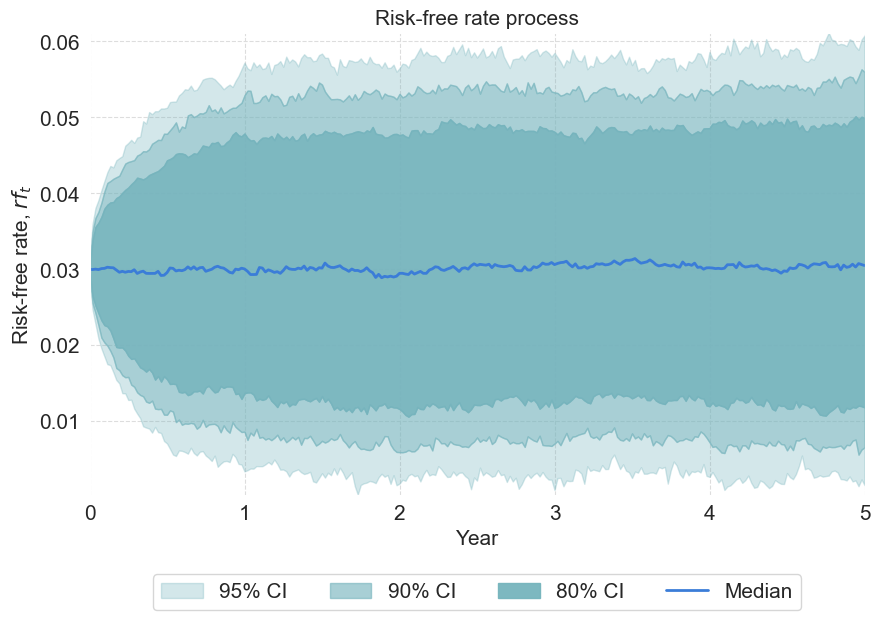

In [175]:
#Plotting the expected value and variance
short_rates = simulate_vasicek(0.03, kappa=1.0, theta=0.03, beta=0.02, horizon=5, dt=1.0/52.0, num_sim=1000)
time_points = np.arange(0, 5.01, 1.0/52.0)

# calculate percentiles
percentiles = np.percentile(short_rates, [2.5, 5, 10, 50, 90, 95, 97.5], axis=0)

"""
Plot fan chart
"""

fig, ax = plt.subplots(figsize=(10, 6))

fan_chart(time_points,
          percentiles,
          color=default_colors['cyan'],
          color_median=default_colors['dark_blue'],
          labels=['95% CI', '90% CI', '80% CI', 'Median'],
          ax=ax)

ax.set_xlabel("Year", size=15)
ax.set_ylabel("Risk-free rate, $rf_t$", size=15)
ax.set_title("Risk-free rate process", size=15)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=15);

In [188]:
#Compounded returns over 5 years 
mean_rf=short_rates.mean()
compounded_rf=1*np.exp(mean_rf*5)
compounded_rf

1.1631503468257531

0.030226428036376415

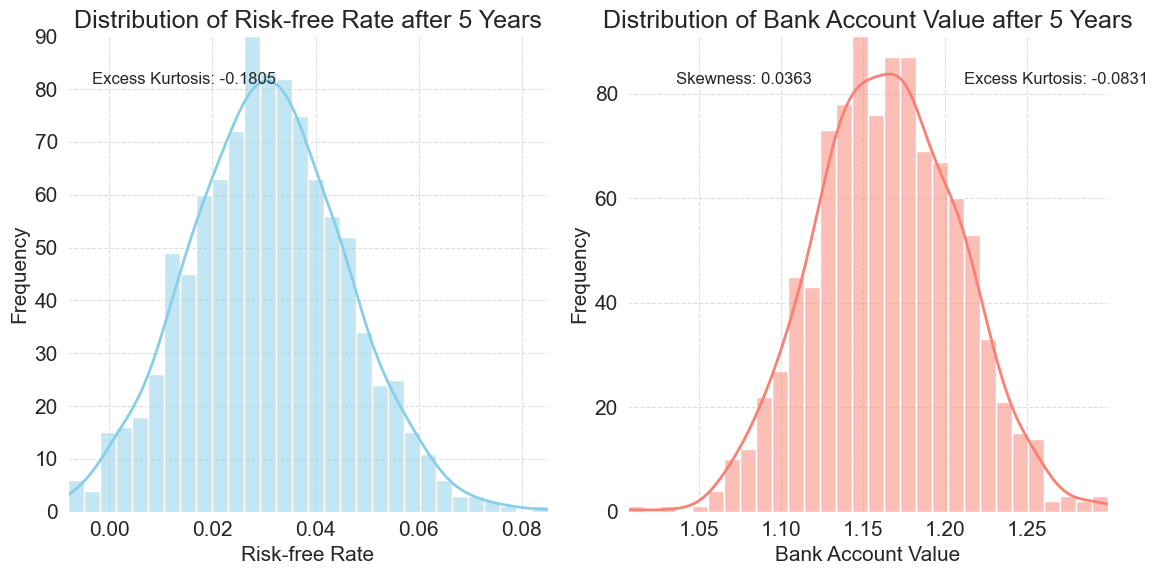

In [187]:
#PLotting the distribution of the risk-free asset and the bank account.
np.random.seed(123)
time_steps = np.arange(0, horizon + dt, dt)
horizon=1/52

# Simulating bank account using short rates
bank_account = np.exp(np.cumsum(short_rates * horizon , axis=1))

# Calculate excess kurtosis and skew
excess_kurtosis_short_rate = kurtosis(short_rate[:, -1], fisher=True)
excess_kurtosis_bank_account = kurtosis(bank_account[:, -1], fisher=True)
from scipy.stats import skew
skew_bank_account=skew(bank_account[:, -1])

# Plotting
plt.figure(figsize=(12, 6))

# Plot the distribution of the short rate
plt.subplot(1, 2, 1)
sns.histplot(short_rates[:, -1], kde=True, bins=30, color="skyblue")
plt.title("Distribution of Risk-free Rate after 5 Years")
plt.xlabel("Risk-free Rate")
plt.ylabel("Frequency")
# Display the excess kurtosis
plt.text(0.05, 0.9, f'Excess Kurtosis: {excess_kurtosis_short_rate:.4f}', transform=plt.gca().transAxes, fontsize=12)

# Plot the distribution of the bank account value
plt.subplot(1, 2, 2)
sns.histplot(bank_account[:, -1], kde=True, bins=30, color="salmon")
plt.title("Distribution of Bank Account Value after 5 Years")
plt.xlabel("Bank Account Value")
plt.ylabel("Frequency")

# Display the excess kurtosis for bank account value
plt.text(0.70, 0.9, f'Excess Kurtosis: {excess_kurtosis_bank_account:.4f}', transform=plt.gca().transAxes, fontsize=12)
plt.text(0.10, 0.9, f'Skewness: {skew_bank_account:.4f}', transform=plt.gca().transAxes, fontsize=12)
plt.tight_layout()
plt.show()


**2.2 Optimal portfolio wehigt invsted in the risky asset**

In [190]:
#Analytical mean of risky asset, assuming continues compounding

# Parameters
mu = 0.06     # expected return
sigma = 0.15  # standard deviation of returns
T = 5         # investment horizon

# Calculate expected log return
expected_return = np.exp((mu + 0.5 * (sigma**2))*5)-1
analy_vari=(sigma**2)*T
print(f'Expected return over the investment horizon: {expected_return*100:.2f}%')
print(f'Variance of the portfolio return over the investment horizon: {analy_vari:.6f}')

Expected return over the investment horizon: 42.80%
Variance of the portfolio return over the investment horizon: 0.112500


In [191]:
#Defining simulation  funcion  
np.random.seed(123)
def simulate_asset_prices(mu: np.ndarray, cov_mat: np.ndarray,
                          horizon: float, dt: float, num_sim: int,
                          transform_input: bool=False) -> np.ndarray:
    
    """
    Simulates asset prices
    
    Parameters
    ----------
    mu: 
        Expected log-returns. 
    cov_mat: 
        Covariance matrix of log-returns. 
    horizon: 
        Simulation horizon in years. 
    dt: 
        Time step. 
    num_sim: 
        Number of simulations. 
    transform_input: 
        Boolean indicating whether to transform mu and cov_mat to time_step. 
    
    
    Returns
    -------
    np.ndarray
        Simulated asset prices  [num sim x num time steps x num_assets]. 
    
    
    """
    
    if transform_input:
        mu = mu * dt
        cov_mat = cov_mat * dt
        
    num_assets = len(mu)
    
    num_periods = int(horizon / dt)
    
    # allocate memory
    asset_prices = np.ones((num_sim, 1 + num_periods, num_assets))
    
    # simulate returns
    log_ret = np.random.multivariate_normal(mu, cov_mat,
                                            size=(num_sim, num_periods))
    
    # transform returns to asset prices
    asset_prices[:, 1:, :] = np.exp(np.cumsum(log_ret, axis=1))
    
    return asset_prices

In [222]:
#finding the expected value of the asset over 5 years so i can find the optimal share in the risky asset
#SEt the parameters for the simulation of asset prices
np.random.seed(123)
mu2 = 0.0
mu1 = 0.06
sigma2 = 0.0
sigma1 = 0.15
rho = 0.0
initial_values = np.array([1.0,0.0])
#paths = np.zeros((num_paths, num_steps + 1, 2))


num_sim = 1000
mu=np.log(1+np.array([mu1,mu2]))
cov_mat= np.array([
    [sigma1**2, rho * sigma1 * sigma2],
    [rho * sigma1 * sigma2, sigma2**2]])

dt = 1.0 # 1.0/12.0                     #Montly intervals
horizon = 5.0                           #Remeber to modify depending on the estimation !!!!

time_points = np.arange(0.0, horizon + 0.01, dt)
asset_prices  = simulate_asset_prices(mu, cov_mat, horizon, dt, num_sim)
#asset_prices_3  = simulate_asset_prices(mu, cov_mat, horizon, dt, num_sim)
#asset_prices_1 = simulate_asset_prices(mu, cov_mat, horizon, dt, num_sim)

prices_asset1=asset_prices[:, 0:, 0]

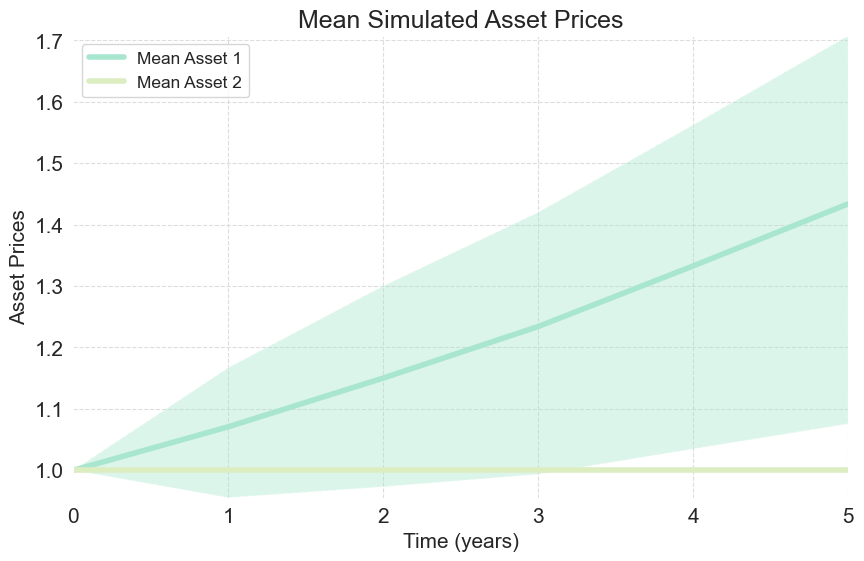

In [198]:
#Vizualising simulated asset prices to check if the code workes as wanted
num_assets = len(mu)
time_points = np.arange(0.0, horizon + dt, dt)

#Vizualising assets
mean_prices = np.mean(asset_prices, axis=0)[:, :]
median_prices = np.median(asset_prices, axis=0)[:, :]
percentile_25 = np.percentile(asset_prices, 25, axis=0)[:, :]
percentile_75 = np.percentile(asset_prices, 75, axis=0)[:, :]
# Plotting
plt.figure(figsize=(10, 6),facecolor='white')

for asset in range(num_assets):
    plt.plot(time_points, mean_prices[:, asset], label=f'Mean Asset {asset+1}',linewidth=4, linestyle='-')
    plt.fill_between(time_points, percentile_25[:, asset], percentile_75[:, asset], alpha=0.4,linestyle='--')

plt.xlabel('Time (years)')
plt.ylabel('Asset Prices')
plt.title('Mean Simulated Asset Prices')
plt.legend(loc='upper left', fontsize='small')
plt.grid(True)
plt.show()

In [223]:
expected_value_asset1 = np.mean(prices_asset1[:,5])
(expected_value_asset1-1)*100
#### THat seems very high?? But it is in line with the analytical returns. Strange that the continuously compounded analytical returns
# have a lower expectation then the simulated 

43.396599149621906

In [225]:
variance_asset1 = np.var(prices_asset1[:,5])
variance_asset1


0.24198373734556772

**Finding the optimal risk adjusted returns for the a BH rebalancing portfolio, with on risk free and one risky asset**

In [322]:
#finding the expected value of the asset over 5 years so i can find the optimal share in the risky asset
#SEt the parameters for the simulation of asset prices
np.random.seed(123)
mu2 = short_rates.mean()
mu1 = 0.06
sigma2 = short_rates.std()
sigma1 = 0.15
rho = 0.0
initial_values = np.array([1.0,1.0])
#paths = np.zeros((num_paths, num_steps + 1, 2))


num_sim = 1000
mu=np.log(1+np.array([mu1,mu2]))
cov_mat= np.array([
    [sigma1**2, rho * sigma1 * sigma2],
    [rho * sigma1 * sigma2, sigma2**2]])

dt = 1.0 # 1.0/12.0                     #Montly intervals
horizon = 5.0                           #Remeber to modify depending on the estimation !!!!

time_points = np.arange(0.0, horizon + 0.01, dt)
asset_prices  = simulate_asset_prices(mu, cov_mat, horizon, dt, num_sim)
#asset_prices_3  = simulate_asset_prices(mu, cov_mat, horizon, dt, num_sim)
#asset_prices_1 = simulate_asset_prices(mu, cov_mat, horizon, dt, num_sim)



In [270]:
from scipy.optimize import minimize

# Function to calculate Sharpe ratio
def sharpe_ratio(weights, mu, cov_mat):
    port_return = weights @ mu
    port_vol = np.sqrt(weights @ cov_mat @ weights.T)
    return -port_return / port_vol  # Minimize negative Sharpe ratio

# Define common constraints
sum_to_one_cons = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0}
no_short_cons = {'type': 'ineq', 'fun': lambda x: x}

# Alternatively, use bounds
bounds = [(0.0, 1.0)] * num_assets

# Calculate the best Sharpe ratio and weights for each investment horizon
for horizon in investment_horizons:
    num_periods = int(horizon / dt)
    log_returns = np.log(asset_prices[:, 1:num_periods+1, :] / asset_prices[:, :num_periods, :])
    mu = np.mean(log_returns, axis=(0, 1))
    cov_mat = np.cov(log_returns.reshape(-1, num_assets), rowvar=False)

    # Initial guess for weights (uniform)
    initial_weights = np.ones(num_assets) / num_assets

    # Perform optimization with constraints
    result = minimize(sharpe_ratio, initial_weights, args=(mu, cov_mat),
                      method='SLSQP', constraints=[sum_to_one_cons, no_short_cons], bounds=bounds)

    # Extract optimized weights
    best_weights_BH = result.x

    # Calculate the Sharpe ratio for the optimized weights
    best_sharpe_ratio = -result.fun

    print(f"Investment Horizon: {horizon} years")
    print(f"Best Sharpe Ratio: {best_sharpe_ratio}")
    print(f"Best Weights: {best_weights_BH}\n")


Investment Horizon: 5 years
Best Sharpe Ratio: 2.2600615538863242
Best Weights: [0.01312238 0.98687762]


In [279]:
#Checking end of period wealth for utility and BH
W0 = 1000000  # Initial wealth in USD
mu=np.array([mu1,mu2])
#Portfolio return
portfolio_return_BH = np.sum(best_weights_BH * mu*5)
portfolio_return_U = np.sum([0.5626,(1-0.5625)] * mu*5)
#End-of-period wealth
WT_BH = W0 * (1 + portfolio_return_BH)
WT_U = W0 * (1 + portfolio_return_U)
print(f"End-of-Period Wealth: {WT_BH:.2f} USD")
print(f"End-of-Period Wealth_utility_opt: {WT_U:.2f} USD")

End-of-Period Wealth: 1153085.64 USD
End-of-Period Wealth_utility_opt: 1234900.31 USD


**Finding the optimal risk adjusted returns for the a CONSTANT MIX rebalancing portfolio, with on risk free and one risky asset**

In [280]:
#Defining the function
np.random.seed()
"""
Constant mix porfolio (monthly rebalancing)
"""

def calculate_period_returns(index: np.ndarray) -> np.ndarray:
    
    """
    Calculates period returns
    
    Paramters
    ---------
    index: 
        Index values [num sim x num time steps x num_assets]. 
        
    Returns
    -------
    np.ndarray
        Period returns. 
    
    """
    
    # get size of matrix
    n = index.shape[1]

    # get matrix not lagged
    new_mat = index[:, 1:n]
    # get matrix lagged
    old_mat = index[:, 0:n-1]
    # get 1 + return
    periodtr = new_mat / old_mat
    
    return periodtr - 1
    

def calculate_constant_mix_index(index: np.ndarray, weights: np.ndarray) -> np.ndarray:
    
    """
    Calculates cum. return index of a constant mix strategy. 
    
    Parameters
    ----------
    index: 
        Index values  [num sim x num time steps x num_assets]. 
    weights: 
        Portfolio weights. 
        
    
    Returns
    -------
    np.ndarray
        Cum. return index [num sim x num time steps]. 
    
    """
    
    port_index = np.ones((index.shape[0], index.shape[1]))
    
    # calculate period returns on assets
    per_ret = calculate_period_returns(index)
    
    # calculate port. period return
    port_per_ret = per_ret @ weights
    
    # calculate port. index
    port_index[:, 1:] = np.cumprod(1 + port_per_ret, axis=1)
    
    return port_index

In [300]:
######Optimizing for the constant mix. Variance is the opjective 
np.random.seed(123)

def objective_function(x, cov_mat):
    return -portfolio_variance(x, cov_mat)


# define common constraints
sum_to_one_cons = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0}
no_short_cons = {'type': 'ineq', 'fun': lambda x: x}

# alternatively use
bounds = [(0.0, 1.0)] * 2

def target_return_constraint(x, asset_prices):
    return np.mean(calculate_constant_mix_index(asset_prices, x)[:, -1])

port_weights = list()
targets =()
for target in targets:
    print(target)

    # define constraint
    target_cons = {'type': 'eq', 'fun': lambda x: target_return_constraint(x, target, asset_prices)}

    x0 = np.ones(2) / 2.0
    res = optimize.minimize(objective_function, x0=x0, args=(cov_mat,),
                            method='SLSQP',
                            constraints=[sum_to_one_cons, target_cons],
                            options={'ftol': 1e-9, 'disp': True}, bounds=bounds)

    port_weights.append(res.x)

port_weights = np.array(port_weights)
##Not getting this to work correctly

TypeError: target_return_constraint() missing 2 required positional arguments: 'x' and 'asset_prices'

In [299]:
port_weights

array([], dtype=float64)

In [325]:
import numpy as np

# Parameters
dt = 1.0/52.0  # weekly rebalancing
num_sim = 1000
gamma = 2
W0 = 1000000
c = 700000
m = 2.5
b = 1

# Time points
time_points = np.arange(0.0, horizon + dt, dt)
num_steps = len(time_points)

# Simulate asset prices
#asset_prices = simulate_asset_prices(mu, cov_mat, horizon, dt, num_sim)

# Initialize wealth and utility arrays
wealth = np.zeros((num_sim, num_steps))
utility = np.zeros((num_sim, num_steps))

# Initial wealth
wealth[:, 0] = W0

# Iterate over each time step
for t in range(1, num_steps):
    # Calculate cushion
    Ct = wealth[:, t-1] - c * asset_prices[:, t, 1]

    # Calculate allocation to risky asset
    hrisky = np.minimum(m * Ct, b * wealth[:, t-1]) / asset_prices[:, t, 1]

    # Update wealth
    wealth[:, t] = hrisky * asset_prices[:, t, 1] + (wealth[:, t-1] - hrisky * asset_prices[:, t-1, 1]) * np.exp(mu[1] * dt)

    # Calculate utility
    utility[:, t] = wealth[:, t]**(1-gamma) / (1 - gamma)

# Final wealth and utility
W5 = wealth[:, -1]
U5 = utility[:, -1]


IndexError: index 6 is out of bounds for axis 1 with size 6

In [321]:
W5.mean()


-2307262923726.1855

**2.6 Visualize the evolution of the zero-coupon bond price that has an initial time to maturity of 5 years**

In [ ]:

#Function returning the price of a zero cupon bond
def calculate_zero_coupon_price(time_to_maturity: Union[float, np.ndarray],
                                initial_short_rate: float,
                                kappa: float,
                                theta: float,
                                beta: float,
                                risk_premium: float):
    
    y_infty = theta - risk_premium * beta / kappa - beta**2 / (2 * kappa**2)
    
    b = 1 / kappa * (1 - np.exp(-kappa * time_to_maturity))
    a = y_infty * (time_to_maturity  - b) + beta**2 / (4 * kappa) * b**2
    
    return np.exp(- a - b * initial_short_rate)


#parameter values
r0 = 0.03
kappa = 1.0
theta = 0.03
beta = 0.02
risk_premium = -0.02 

#Simulation parameters
horizon = 5  
num_simulations = 1000

##Simulate short rate paths
short_rate_paths = simulate_vasicek(r0, kappa, theta, beta, horizon, num_sim=num_simulations)

# Calculate zero-coupon bond prices
time_to_maturity = np.linspace(0, horizon, short_rate_paths.shape[1])
zero_coupon_prices = calculate_zero_coupon_price(time_to_maturity, r0, kappa, theta, beta, risk_premium)

# Plot the results
plt.figure(figsize=(10, 6))
for i in range(num_simulations):
    plt.plot(time_to_maturity, zero_coupon_prices * np.exp(-short_rate_paths[i]))

plt.title('Zero-Coupon Bond Price Evolution')
plt.xlabel('Time to Maturity (years)')
plt.ylabel('Zero-Coupon Bond Price')
plt.grid(True)
plt.show()


In [ ]:
####Vizualising the mean of the price paths!
mean_prices = np.mean(zero_coupon_prices * np.exp(-short_rate_paths), axis=0)

plt.figure(figsize=(10, 6))
plt.plot(time_to_maturity, mean_prices,color='blue', linewidth=2, label='Mean Zero-Coupon Bond Price')
plt.title('Mean Zero-Coupon Bond Price Evolution')
plt.xlabel('Time to Maturity (years)')
plt.ylabel('Mean Zero-Coupon Bond Price')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Calculate yields for the ZCB-price paths
time_to_maturity = np.linspace(0.1, horizon, short_rate_paths.shape[1])
yields = -np.log(zero_coupon_prices) / time_to_maturity

# Plot the yield curve
plt.figure(figsize=(12, 8))
plt.plot(time_to_maturity, yields.T, alpha=0.1, color='green')  # Individual paths
#plt.plot(time_to_maturity, np.mean(yields, axis=0), color='blue', linewidth=2, label='Mean Yield')
plt.title('Yield Curve Evolution')
plt.xlabel('Time to Maturity (years)')
plt.ylabel('Yield')
plt.legend()
plt.grid(True)
plt.show()

### Not getting to work correctly! need to check later !!!!!!!!!!!!!!!!!!!!!!!!